In [10]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Application of a GARCH Model on S&P500 price data for volatility forecasting

### First set up the data

In [11]:
# read SP500 data
spy = pd.read_csv('SP500.csv')

In [12]:
# 1. calculate returns, use the adjusted close price
spy['ret'] = spy['Adj Close'].pct_change()

# 2. clean up NaN values
spy = spy.dropna()

# 3. format the index to datetime
spy.index = pd.to_datetime(spy['Date'])

### Analyze the data

<AxesSubplot: xlabel='Date'>

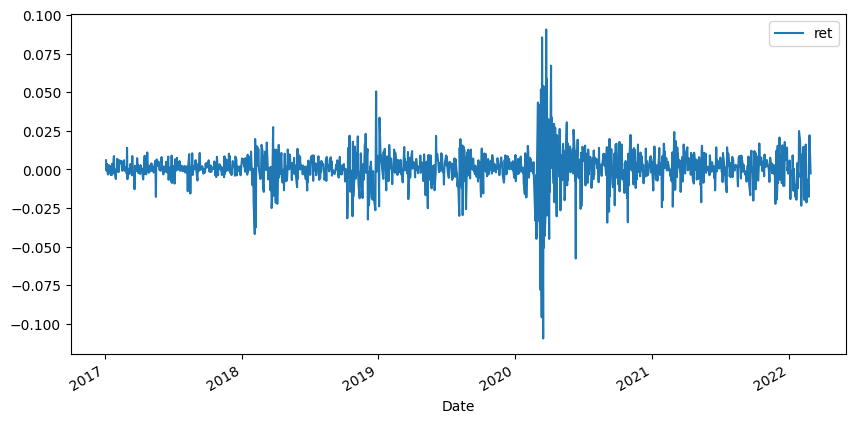

In [13]:
# visualize returns
spy.plot(y='ret', figsize=(10,5))

> Observation: <br> We can see heteroscedasticity and volatility clustering

In [18]:
# fit model to calculate residuals (in this case simple de-meaning with OLS)
model = smf.ols(formula='ret ~ 1', data=spy).fit()
spy['res'] = model.resid

#get squared residuals
spy['res2'] = spy['res']**2*100*100




<AxesSubplot: xlabel='Date'>

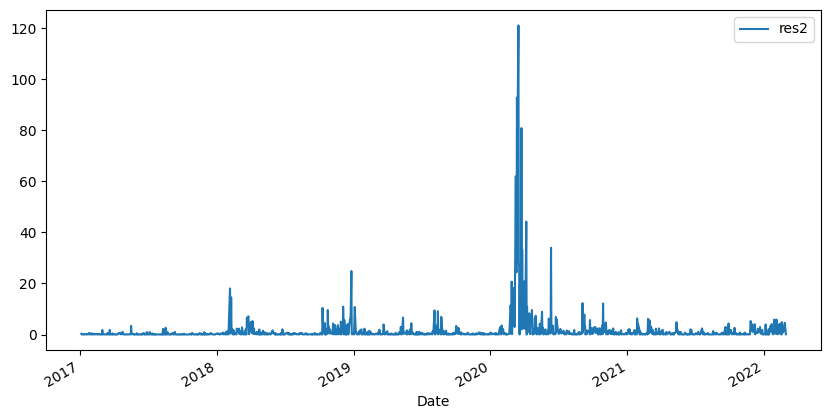

In [19]:
# visualize squared residuals (variance)
spy.plot(y='res2', figsize=(10,5))

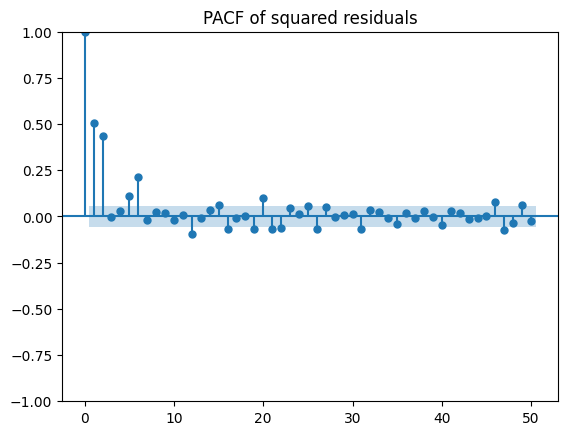

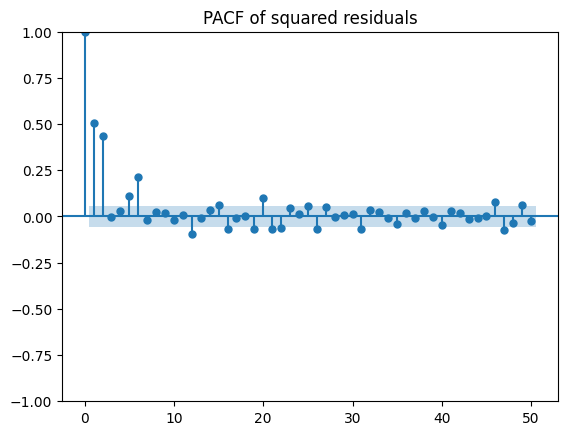

In [20]:
# analyze PACF of the squared resiuduals
plot_pacf(spy['res2'], lags=50, title='PACF of squared residuals')



### Fit the Model

In [25]:
# use this function
from arch import arch_model

# fit a GARCH model on the sample and inspect the significance of the coeffs
# hint: first research how to apply the imported ARCH model
#split in train (until 2019) and test
spy_train = spy.loc[:'2019-12-31']
spy_test = spy.loc['2020-01-01':]
model_garch = arch_model(spy_train['res'], mean='Zero', vol='GARCH', p=15, q=15)
res_garch = model_garch.fit(disp='off')
print(res_garch.summary())





                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    res   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2640.57
Distribution:                  Normal   AIC:                          -5219.14
Method:            Maximum Likelihood   BIC:                          -5075.79
                                        No. Observations:                  753
Date:                Fri, Nov 11 2022   Df Residuals:                      753
Time:                        13:45:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.5151e-06  1.871e-09   3481.715      0.000 

### Now the fun part: Volatility Forecasting 
We want to create a rolling forecast of conditional variance with an appropriate GARCH model

In [30]:
# define start of the prediction
pred_start = datetime(2019,1,1)

# get dates for forecast
pred_dates = pd.date_range(start=pred_start, end=spy_test.index[-1], freq='D')
model_garch = arch_model(spy['res'], mean='Zero', vol='GARCH', p=15, q=15)
res_garch = model_garch.fit(disp='off')
pred = res_garch.forecast(horizon=len(pred_dates))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


ValueError: Must have equal len keys and value when setting with an iterable

In [27]:
# set your arch model
# forecast from 1.1.2019 to the end
# access every new value from 2019 onwards through a loop
# for every new value fit the arch model again on all "historic values"
# forecast the next timestep and calculate the variance of the forecast
# save the forecast in an extra column of the SP500 dataframe

spy['forecast'] = pred


NameError: name 'pred' is not defined

### Compare the forecast to actual values

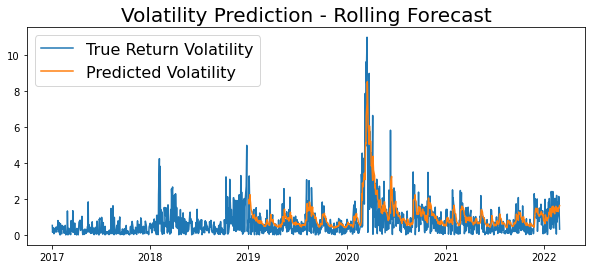

In [ ]:
# plot true volatility (residuals) vs GARCH foracested volatility (vola = sqrt of variance)